# Script for Collecting Data

Collects and analyzes measurements from the **Pressure** and **Float** sensors.

In [17]:
import serial
import serial.tools
import serial.tools.list_ports
import re
import time
import math

ser = None
for port in serial.tools.list_ports.comports():
    if port.description.find('Arduino Uno') != -1:
        ser = serial.Serial(port.name, baudrate=9600)

time_data = []
pressure_data = []
float_data = []

def get_height_from_pressure(voltage):
    P = 144.0*((voltage - 0.5)*5/(4.5)) # psf
    rho = 1.94 # slugs/ft^3
    g = 32.2 # ft/s^2
    return (P / (rho*g)) * 12.0 # in

def get_height_from_float(voltage):
    H = 3.25 # in
    L = 3.5 # in
    POS_MIN_VOLTAGE = 0.13213 # V
    POS_MAX_VOLTAGE = 0.08701 # V <— other potentiometer
    # MULTIPLIER = 45 / (0.05859 - POS_MIN_VOLTAGE)
    # MULTIPLIER = 34.849 / (POS_MIN_VOLTAGE - POS_MAX_VOLTAGE)
    theta = 34.849 * (voltage - POS_MAX_VOLTAGE)/(POS_MIN_VOLTAGE - POS_MAX_VOLTAGE)# degrees
    theta = 0.0 if theta < 0.0 else theta
    # f_height = theta
    f_height = H - (L*math.sin(math.radians(theta)) + 0.84375) # in
    return f_height
    # Just using proportionals (assuming linear)
    # return H - (3.5 * (voltage - POS_MIN_VOLTAGE) / (POS_MAX_VOLTAGE - POS_MIN_VOLTAGE))

def remove_height_scaling_from_float(height):
    H = 3.25 # in
    L = 3.5 # in
    POS_MIN_VOLTAGE = 0.13213 # V
    POS_MAX_VOLTAGE = 0.08701 # V <— other potentiometer
    # MULTIPLIER = 45 / (0.05859 - POS_MIN_VOLTAGE)
    MULTIPLIER = 34.849 / (POS_MAX_VOLTAGE - POS_MIN_VOLTAGE)
    voltage = (-height + H * (POS_MAX_VOLTAGE - POS_MIN_VOLTAGE) / 3.5) + POS_MIN_VOLTAGE 
    theta = 360*(voltage - POS_MIN_VOLTAGE) / (POS_MAX_VOLTAGE - POS_MIN_VOLTAGE)

## Data Collection

This code block collects the measurements from the Arduino

In [18]:
try:
    while True:
        start_time = time.time()
        read_line = ser.read_until(b'\n').decode('utf-8')
        try:
            times = re.findall(r'T: \d+', read_line)[0]
            pressures: tuple[str] = re.findall(r'(P: \d+(\.\d+)?)', read_line)[0]
            floats: tuple[str] = re.findall(r'(F: \d+(\.\d+)?)', read_line)[0]
        except IndexError:
            continue
        pressure_voltage = None
        float_voltage = None
        
        time_seconds = float(times[3:])
        for entry in pressures:
            if entry.startswith('P'):
                pressure_voltage = float(entry[3:])
        for entry in floats:
            if entry.startswith('F'):
                float_voltage = float(entry[3:])
        
        if (pressure_voltage is None or float_voltage is None): continue
        print(f"Time: {time_seconds}\tPressure: {pressure_voltage} V\tFloat: {float_voltage} V")
        time_data.append(time_seconds)
        pressure_data.append(get_height_from_pressure(pressure_voltage))
        float_data.append(get_height_from_float(float_voltage))
except KeyboardInterrupt:
    pass


Time: 100.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 201.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 303.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 405.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 506.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 609.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 710.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 812.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 914.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 1015.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 1118.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 1219.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 1321.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 1423.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 1525.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 1627.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 1728.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 1830.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 1932.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 2034.0	Pressure: 0.50781 V	Float: 0.13535 V
Time: 213

## Export Data

Export data to CSV for Excel or MATLAB.

In [20]:
import pandas as pd

pressure = pd.DataFrame({
    "Time": time_data,
    "Height": pressure_data
})
float = pd.DataFrame({
    "Time": time_data,
    "Height": float_data
})

# Export data to CSV
pressure.to_csv("pressure_data.csv")
float.to_csv("float_data.csv")

In [ ]:
old_pressure_data = pressure_data
old_float_data = float_data

In [ ]:
pressure_data = old_pressure_data

In [ ]:
pressure_data = [
    (x*2.0/1.74087213) for x in pressure_data
]

Text(0, 0.5, 'Height (in)')

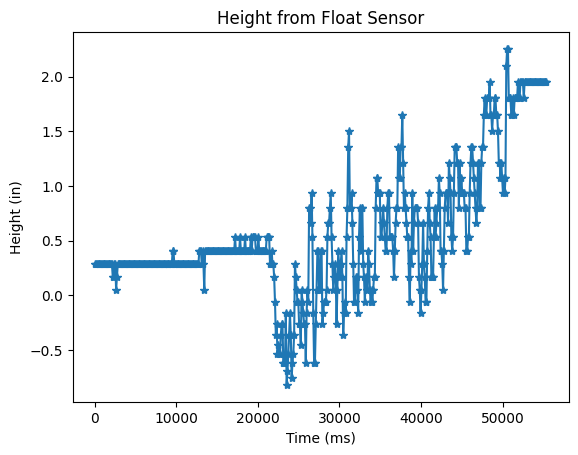

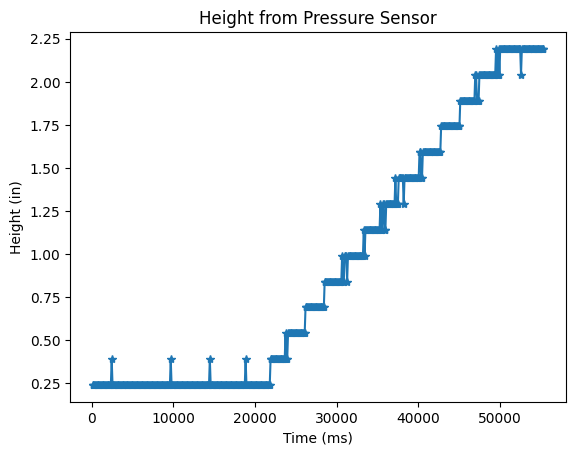

In [19]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.title("Height from Float Sensor")
plt.plot(time_data, float_data, marker='*')
plt.xlabel("Time (ms)")
plt.ylabel("Height (in)")


plt.figure(2)
plt.title("Height from Pressure Sensor")
plt.plot(time_data, pressure_data, marker='*')
plt.xlabel("Time (ms)")
plt.ylabel("Height (in)")

In [12]:
ser.close()